# VGG19

## Get embeddings
I just download this model from Keras and inference it following their example

In [1]:
# Load images
import numpy as np
from PIL import Image
import os

# Training
image_folder = "images/training_imgs"

# Break into categories
clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("c.png")]
clothing_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("c.png")]
clothing_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in clothing_labels]

full_body_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_labels = [file.split("-")[0].split("_") for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_filenames = [file for file in os.listdir(image_folder) if file.endswith("fb.png")]
full_body_labels = [[lab[0], lab[1], lab[2][:-1]] if lab[2].endswith("s") else lab for lab in full_body_labels]

full_body_unedited = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder) if file.endswith("fb-unedited.png")]

# Test
image_folder = "images/example_imgs"

# Break into categories
test_clothing_images = [Image.open(os.path.join(image_folder, file)) for file in os.listdir(image_folder)]

In [2]:
# Create embeddings
import tensorflow as tf

def sample_generator(dataset):
    for sample in dataset:
        yield tf.keras.applications.vgg19.preprocess_input(np.array(sample))

img_spec = tf.TensorSpec((488, 488, 3), float)
ds_clothing = tf.data.Dataset.from_generator(lambda: sample_generator(clothing_images), output_signature=img_spec).batch(32)
ds_outfit = tf.data.Dataset.from_generator(lambda: sample_generator(full_body_images), output_signature=img_spec).batch(32)
ds_test = tf.data.Dataset.from_generator(lambda: sample_generator(test_clothing_images), output_signature=img_spec).batch(32)

model = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(488, 488, 3),
    pooling="avg"
)

clothing_embed = model.predict(ds_clothing)
full_body_embed = model.predict(ds_outfit)
test_embed = model.predict(ds_test)

2024-05-06 02:18:23.037035: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 02:18:23.081733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 02:18:23.755395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-06 02:18:24.612029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute cap

      2/Unknown 13s 106ms/step

I0000 00:00:1714976318.507987 1205869 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 729ms/step


2024-05-06 02:19:06.941769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/ian/miniconda3/envs/tf/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 819ms/step


2024-05-06 02:19:39.711500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2024-05-06 02:19:42.622827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Visualize model embeddings

In [3]:
# Load images
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Break into categories
clothing_pca = PCA(n_components=2).fit(clothing_embed)
print(clothing_pca.explained_variance_ratio_, sum(clothing_pca.explained_variance_ratio_))
clothing_pca = clothing_pca.transform(clothing_embed)
clothing_tsne = TSNE().fit_transform(clothing_embed)

full_body_pca = PCA(n_components=2).fit(full_body_embed)
print(full_body_pca.explained_variance_ratio_, sum(full_body_pca.explained_variance_ratio_))
full_body_pca = full_body_pca.transform(full_body_embed)
full_body_tsne = TSNE().fit_transform(full_body_embed)

[0.20846431 0.11227033] 0.3207346424460411
[0.14777923 0.10261279] 0.25039201974868774


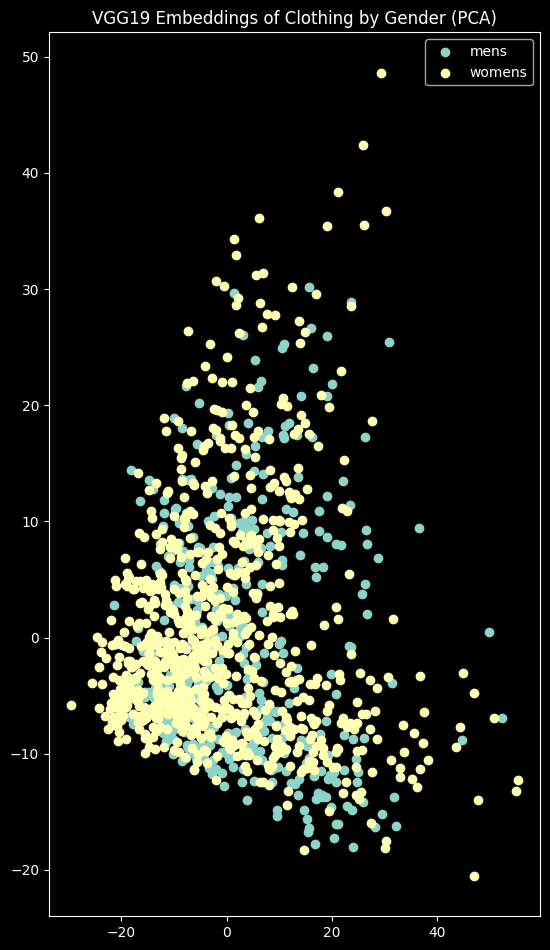

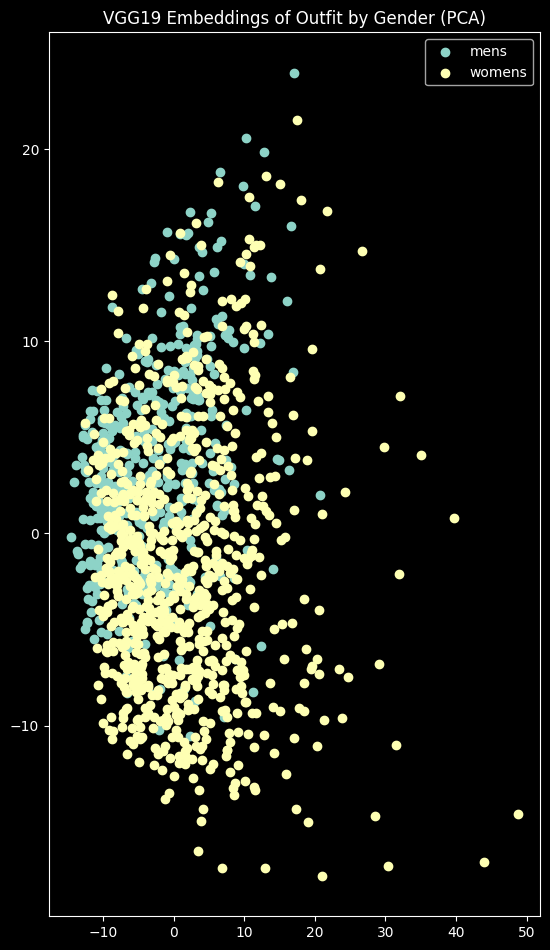

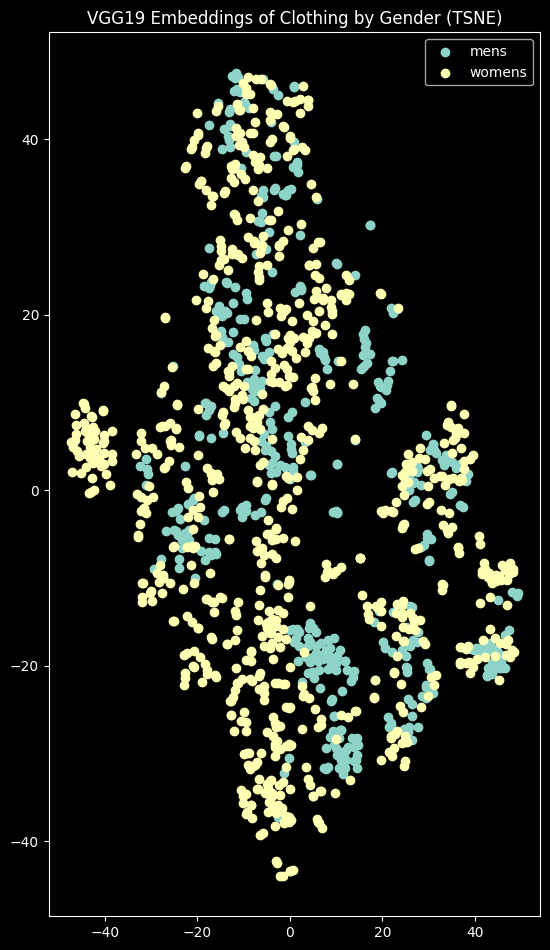

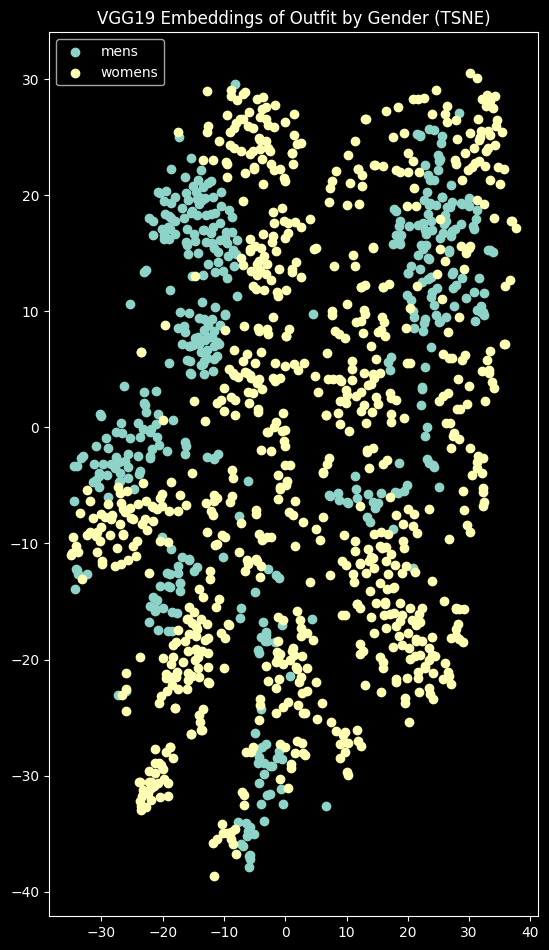

In [4]:
# Plot gendered items
import matplotlib.pyplot as plt

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Clothing by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Outfit by Gender (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Clothing by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for gender in ["mens", "womens"]:
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][1] == gender]][:, 1],
        label=gender
    )

plt.title("VGG19 Embeddings of Outfit by Gender (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

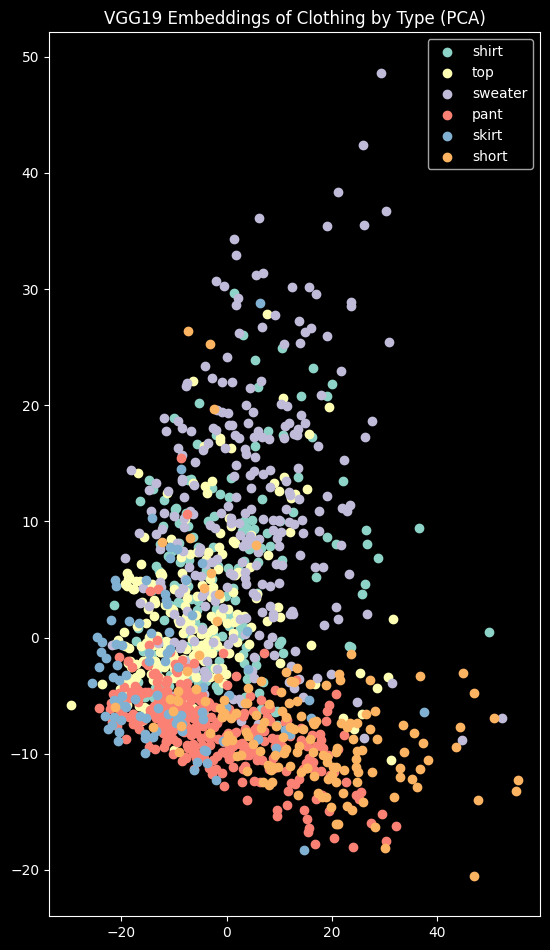

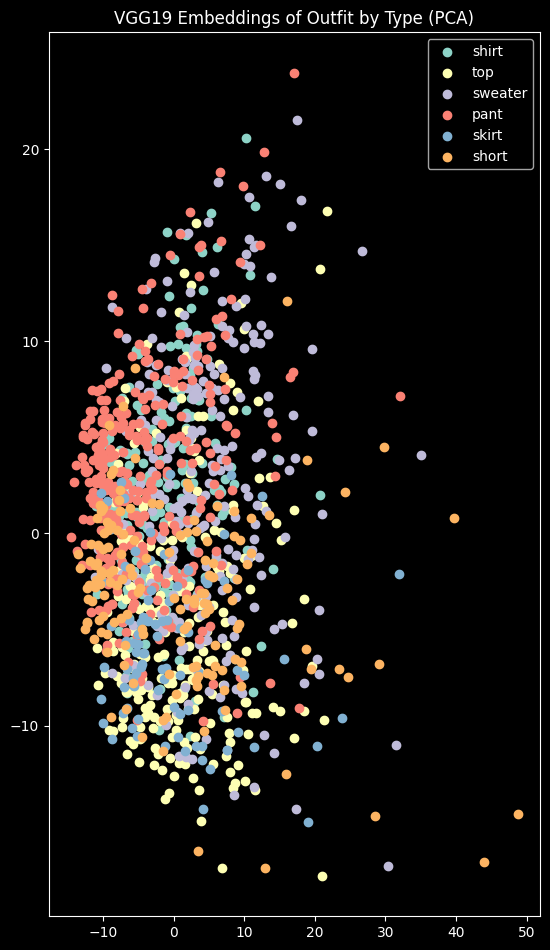

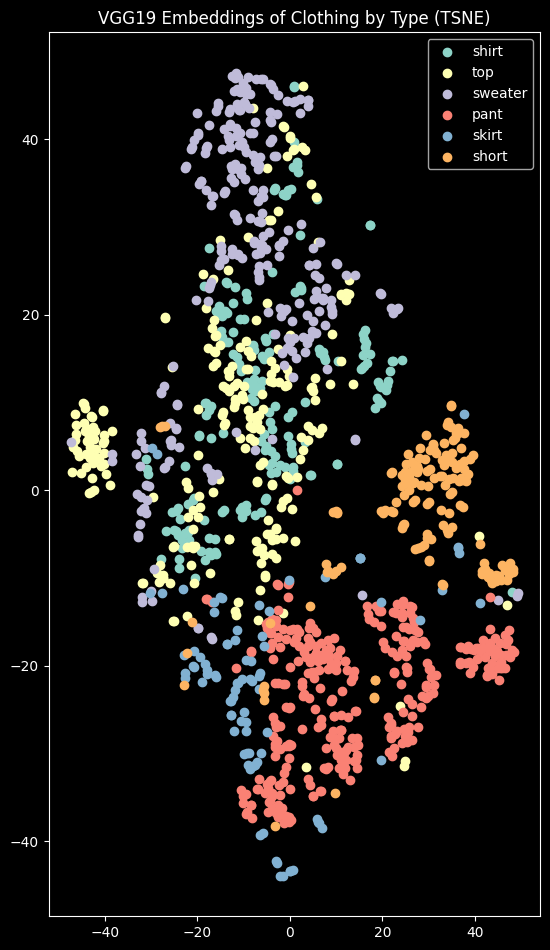

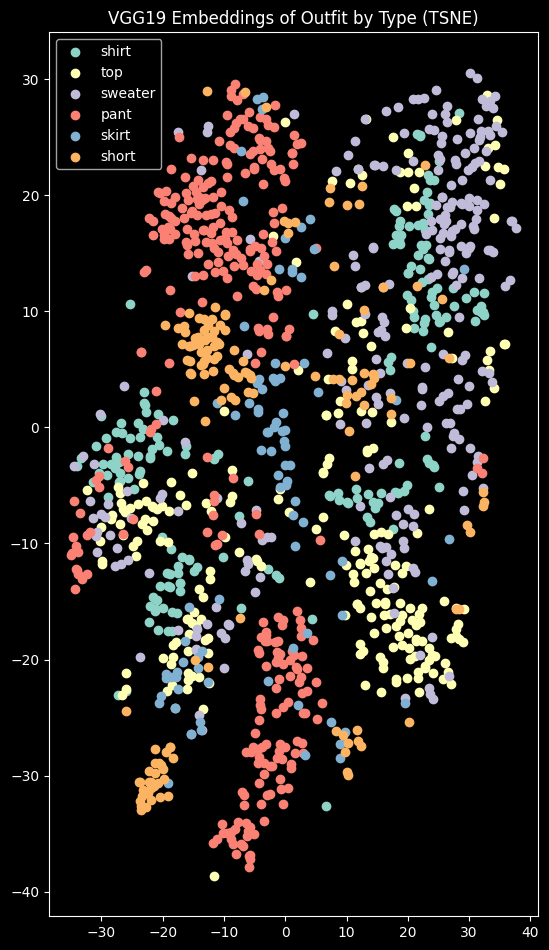

In [5]:
# Plot types of items

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 0],
        clothing_pca[[i for i in range(len(clothing_pca)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Clothing by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 0],
        full_body_pca[[i for i in range(len(full_body_pca)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Outfit by Type (PCA)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:        
    plt.scatter(
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 0],
        clothing_tsne[[i for i in range(len(clothing_tsne)) if clothing_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Clothing by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=[5.6, 9.6])
for item in ["shirt", "top", "sweater", "pant", "skirt", "short"]:    
    plt.scatter(
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 0],
        full_body_tsne[[i for i in range(len(full_body_tsne)) if full_body_labels[i][2] == item]][:, 1],
        label=item
    )
    
plt.title("VGG19 Embeddings of Outfit by Type (TSNE)")
plt.tight_layout()
plt.legend()
plt.show()

## Testing embeddings using KNN

In [6]:
from sklearn.model_selection import train_test_split

y_map = {"shirt": 0, "top": 0, "sweater": 1, "pant": 2, "skirt": 3, "short": 4}
y = np.array([y_map[label[2]] for label in clothing_labels])
X_train, X_test, y_train, y_test = train_test_split(clothing_embed, y, test_size=0.25)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

matrix = confusion_matrix(y_test, knn.predict(X_test))
acc_per_class = matrix.diagonal()/matrix.sum(axis=1)

print(acc_per_class)

[0.95575221 0.81818182 0.975      0.40740741 0.70731707]


## Plot demo outfits

In [8]:
# Refit KNN on all training

knn.fit(clothing_embed, y)

KNeighborsClassifier()

662
527
384
91
1107


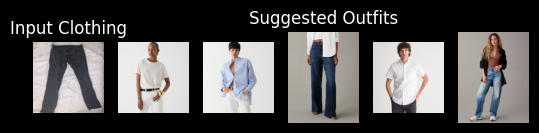

299
732
1173
952
1145


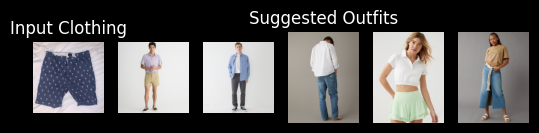

1025
232
534
1060
144


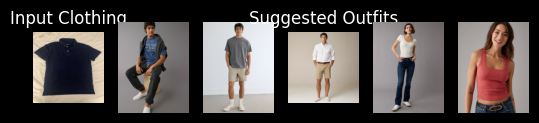

978
965
811
89
1176


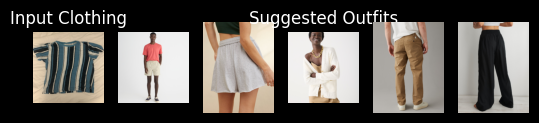

1044
534
1004
554
85


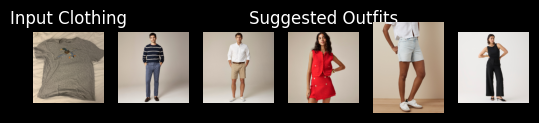

336
636
1109
202
1150


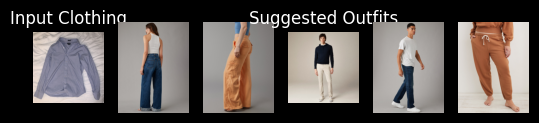

In [9]:
# Generate suggested outfits

for i, test_emb in enumerate(test_embed):
    _, axs = plt.subplots(1, 6)
    axs[0].axis("off")
    # axs[0].set_title("Input Clothing")
    axs[0].imshow(test_clothing_images[i])
    # axs[3].set_title("Suggested Outfits")

    _, inds = knn.kneighbors(np.reshape(test_emb, (1, -1)))
    for j, ind in enumerate(inds[0]):
        print(ind)
        axs[j + 1].axis("off")
        axs[j + 1].imshow(full_body_unedited[ind])

    plt.show()